In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Input, Model, load_model
from keras.layers import Dense, Dropout, BatchNormalization
from keras import optimizers
from tcn import TCN

In [6]:
!pip freeze

absl-py==0.5.0
alabaster==0.7.12
anaconda-client==1.6.14
anaconda-navigator==1.8.1
anaconda-project==0.8.2
asn1crypto==0.24.0
astor==0.7.1
astroid==2.0.4
astropy==3.0.5
atomicwrites==1.2.1
attrs==18.2.0
autopep8==1.4.3
Babel==2.6.0
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.3
bitarray==0.8.3
bkcharts==0.2
blaze==0.11.3
bleach==3.0.2
bokeh==0.13.0
boto==2.48.0
Bottleneck==1.2.1
category-encoders==2.0.0
certifi==2019.3.9
cffi==1.11.5
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
clyent==1.2.2
colorama==0.4.0
comtypes==1.1.7
conda==4.6.13
contextlib2==0.5.5
convertdate==2.1.3
cryptography==2.6.1
cycler==0.10.0
Cython==0.29
cytoolz==0.9.0.1
dask==0.19.4
datashape==0.5.4
DAWG-Python==0.7.2
decorator==4.3.0
defusedxml==0.5.0
distributed==1.23.3
docopt==0.6.2
docutils==0.14
entrypoints==0.2.3
ephem==3.7.6.0
et-xmlfile==1.0.1
fastcache==1.0.2
fbprophet==0.4.post2
filelock==3.0.4
Flask==1.0.2
Flask-Cors==3.0.6
future==0.16.0
gast==0.2.0
gevent==1.3.0
glob2==0.6

In [22]:
np.random.seed(1234)  
model_path = './Output/regression_model.h5'

### Загрузка данных

In [5]:
train_df = pd.read_csv('./data/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [6]:
train_df = train_df.sort_values(['id','cycle'])

In [7]:
test_df = pd.read_csv('./data/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [8]:
truth_df = pd.read_csv('./data/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

### Подготовка таргета

In [9]:
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

### Нормализация

In [10]:
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

c:\users\евгений\lstmkeras\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [11]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [12]:
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [13]:
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

In [14]:
train_df.to_csv('./data/PredictiveManteinanceEngineTraining.csv', encoding='utf-8',index = None)
test_df.to_csv('./data/PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)

In [7]:
train_df = pd.read_csv('./data/PredictiveManteinanceEngineTraining.csv', encoding='utf-8')
test_df = pd.read_csv('./data/PredictiveManteinanceEngineValidation.csv', encoding='utf-8')

### Генерация последовательностей для входа реккурентной сети

In [8]:
sequence_length = 50

In [9]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [10]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

In [11]:
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [12]:
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [13]:
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(15631, 50, 25)


In [14]:
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

### Обучение

In [15]:
def sMAPE(y_true, y_pred):
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_pred) + K.abs(y_true)), axis=-1)

In [16]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [17]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [133]:
batch_size, timesteps, input_dim = None, 50, 25

i = Input(batch_shape=(batch_size, timesteps, input_dim))
bn1 = BatchNormalization(input_shape=(sequence_length, nb_features), momentum=0.67)(i)
tnc1 = TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=[1, 2, 4, 8, 16], padding='same', 
        use_skip_connections=True, dropout_rate=0.2, return_sequences=True, name='tcn')(bn1)
bn2 = BatchNormalization(input_shape=(sequence_length, nb_features), momentum=0.67)(tnc1)
tnc2 = TCN(nb_filters=16, kernel_size=2, nb_stacks=1, dilations=[1, 2, 4, 8], padding='same', 
        use_skip_connections=True, dropout_rate=0.2, return_sequences=False, name='tcn')(bn2)
o = Dense(1)(tnc2)

model = Model(inputs=[i], outputs=[o])
model.compile(loss=root_mean_squared_error, optimizer=adam, metrics=['mae', sMAPE])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 50, 25)       0                                            
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 50, 25)       100         input_19[0][0]                   
__________________________________________________________________________________________________
conv1d_483 (Conv1D)             (None, 50, 32)       832         batch_normalization_12[0][0]     
__________________________________________________________________________________________________
conv1d_484 (Conv1D)             (None, 50, 32)       2080        conv1d_483[0][0]                 
__________________________________________________________________________________________________
activation

In [134]:
history = model.fit(seq_array, label_array, epochs=100, validation_split=0.1, batch_size=256, verbose=2, 
      callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
print(history.history.keys())

Train on 14067 samples, validate on 1564 samples
Epoch 1/100
 - 10s - loss: 47.7941 - mean_absolute_error: 35.3901 - sMAPE: 28.7519 - val_loss: 42.2092 - val_mean_absolute_error: 33.3521 - val_sMAPE: 19.3888
Epoch 2/100
 - 1s - loss: 33.8738 - mean_absolute_error: 23.4734 - sMAPE: 16.9159 - val_loss: 40.3926 - val_mean_absolute_error: 31.0374 - val_sMAPE: 18.0185
Epoch 3/100
 - 1s - loss: 32.0551 - mean_absolute_error: 21.9023 - sMAPE: 15.8528 - val_loss: 38.0895 - val_mean_absolute_error: 28.3840 - val_sMAPE: 14.8853
Epoch 4/100
 - 1s - loss: 30.4023 - mean_absolute_error: 20.5446 - sMAPE: 14.8809 - val_loss: 37.1964 - val_mean_absolute_error: 27.0022 - val_sMAPE: 14.1767
Epoch 5/100
 - 1s - loss: 29.3123 - mean_absolute_error: 19.6797 - sMAPE: 14.3702 - val_loss: 35.6872 - val_mean_absolute_error: 27.1947 - val_sMAPE: 16.3503
Epoch 6/100
 - 1s - loss: 28.6821 - mean_absolute_error: 19.4716 - sMAPE: 14.1821 - val_loss: 34.7731 - val_mean_absolute_error: 24.9357 - val_sMAPE: 13.0350
Ep

### Кривые обучения

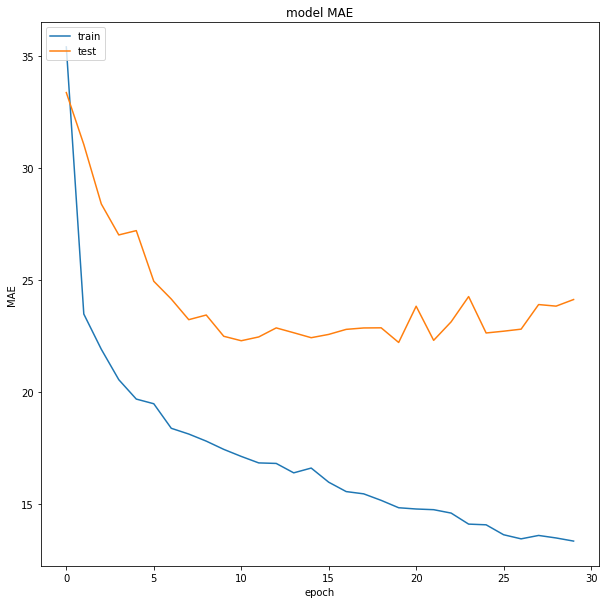

In [135]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Output/model_mae.png")

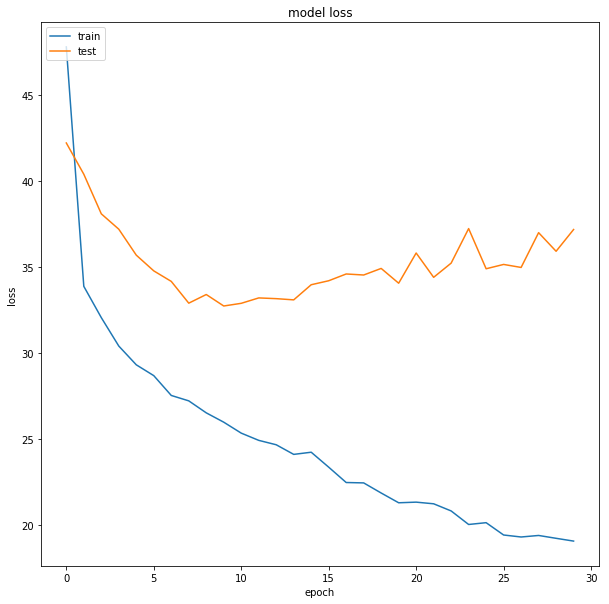

In [136]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Output/model_regression_loss.png")

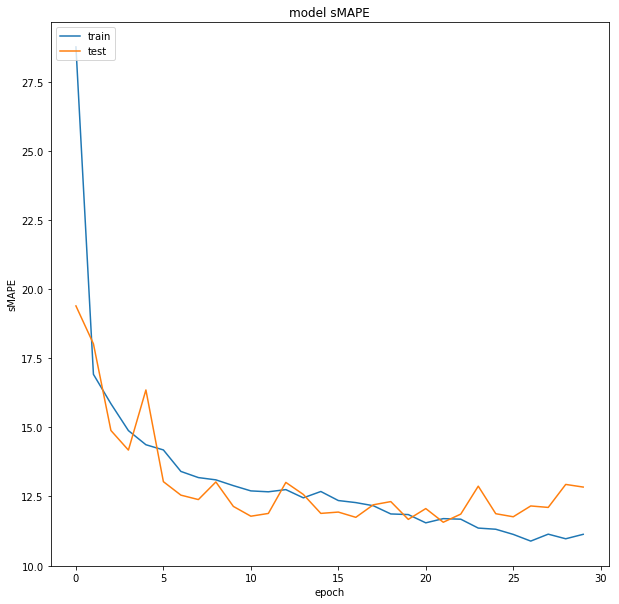

In [137]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['sMAPE'])
plt.plot(history.history['val_sMAPE'])
plt.title('model sMAPE')
plt.ylabel('sMAPE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Output/model_regression_sMAPE.png")

### Валидация

In [138]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))

15631/15631 [==============================] - 1s 38us/step

MAE: 12.169694843924319


In [139]:
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

15631/15631 [==============================] - 3s 198us/step


In [140]:
test_set = pd.DataFrame(y_pred)
test_set.to_csv('./Output/submit_train.csv', index = None)

In [141]:
test_set = pd.read_csv('./Output/submit_train.csv')

In [142]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

In [143]:
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
print(seq_array_test_last.shape)

seq_array_test_last
(93, 50, 25)


In [144]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print("label_array_test_last")
print(label_array_test_last.shape)

label_array_test_last
(93, 1)



MAE: 10.23445975395941


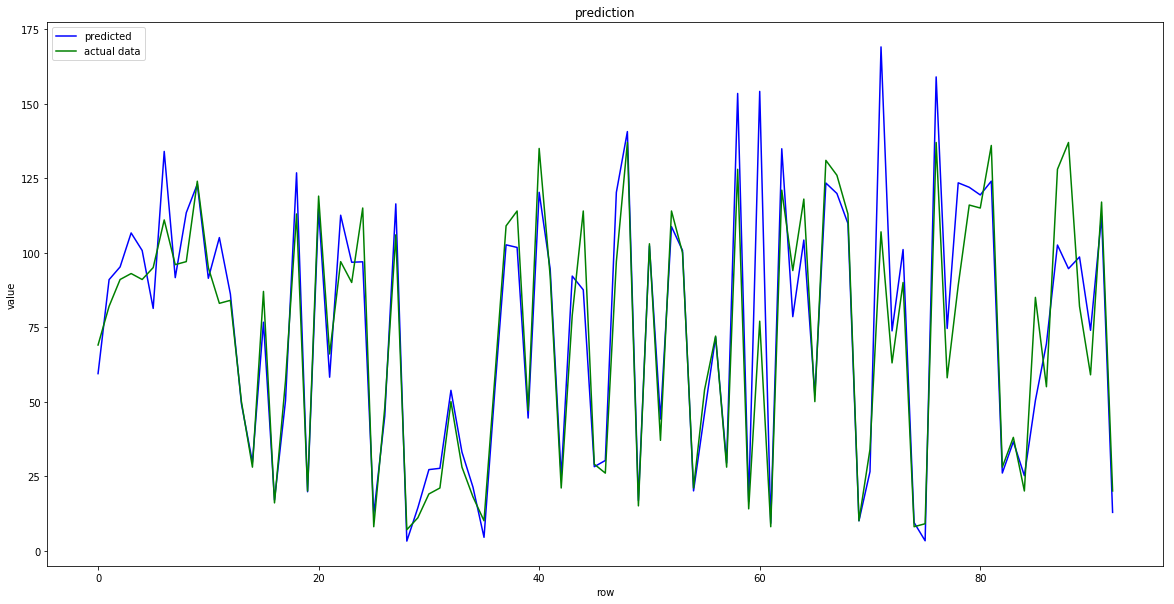

In [145]:
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'root_mean_squared_error': root_mean_squared_error,
                                                     'sMAPE': sMAPE})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('./Output/submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(20, 10))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("./Output/model_regression_verify.png")

In [146]:
keras.utils.plot_model(estimator, to_file='./Output/model.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [147]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+1))) * 100

In [148]:
mean_absolute_percentage_error(y_true_test, y_pred_test)

15.832051634788513

In [149]:
mean_squared_error(y_true_test, y_pred_test)

253.11118

### Кастомная метрика соревнования

In [150]:
def score(y_true, y_pred):
    score = 0
    for true, pred in zip(y_true, y_pred):
        if true > pred:
            score += math.e**((true-pred)/13) - 1
        else:
            score += math.e**((pred-true)/10) - 1
    return score

In [151]:
y_pred_test = estimator.predict(seq_array_test_last)
y_true_test = label_array_test_last

In [152]:
score(y_true_test, y_pred_test)

array([2949.1738], dtype=float32)

Так как метрика штрафует меньше за недопредсказания, можно откалибровать выход модели и получить лучший скор.

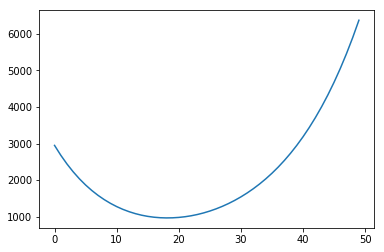

In [153]:
l = []
for i in range(0, 50):
    l.append(score(y_true_test, y_pred_test-i))
plt.plot(l)

In [154]:
l

[array([2949.1738], dtype=float32),
 array([2681.038], dtype=float32),
 array([2440.8892], dtype=float32),
 array([2226.3843], dtype=float32),
 array([2035.0143], dtype=float32),
 array([1865.2313], dtype=float32),
 array([1714.7291], dtype=float32),
 array([1581.7211], dtype=float32),
 array([1464.8835], dtype=float32),
 array([1362.7451], dtype=float32),
 array([1274.2555], dtype=float32),
 array([1198.4697], dtype=float32),
 array([1134.6019], dtype=float32),
 array([1081.5426], dtype=float32),
 array([1038.8962], dtype=float32),
 array([1006.37573], dtype=float32),
 array([983.28076], dtype=float32),
 array([969.25665], dtype=float32),
 array([963.90656], dtype=float32),
 array([966.7208], dtype=float32),
 array([977.5342], dtype=float32),
 array([996.2471], dtype=float32),
 array([1022.8206], dtype=float32),
 array([1057.6136], dtype=float32),
 array([1100.6921], dtype=float32),
 array([1151.9121], dtype=float32),
 array([1211.5309], dtype=float32),
 array([1279.7965], dtype=float

In [155]:
min(l)

array([963.90656], dtype=float32)